In [229]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from tqdm import tqdm

In [230]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [231]:
cuda = torch.cuda.is_available()

In [232]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor   if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor   if use_cuda else torch.ByteTensor
def convert_to_var(arr, astype='float32', add_dim=False):
    if add_dim:
        arr = np.array([arr])
    if astype == 'float32':
        v = Variable(FloatTensor(arr.astype(astype))) 
    else:
        v = Variable(LongTensor(arr.astype(astype)))
    return v

In [233]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [234]:
class VAE(nn.Module):
    def __init__(self, input_shape=(-1, 10),
                 latent_dim=2, n_samples=10,
                 fc_size=1024, num_layers=2):
        super(VAE, self).__init__()
        self.n_samples = n_samples
        self.input_shape = input_shape
        
        encoder_layers = []
        encoder_layers.append(nn.Linear(input_shape[-1], fc_size))
        encoder_layers.append(nn.ReLU())
        for i in range(1,num_layers):
            encoder_layers.append(nn.Linear(fc_size//2**(i-1), fc_size//2**i))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
            
        self.fc_mu = nn.Linear(fc_size//2**(num_layers-1), latent_dim)
        self.fc_logvar = nn.Linear(fc_size//2**(num_layers-1), latent_dim)
        
        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_dim, fc_size//2**(num_layers-1)))
        decoder_layers.append(nn.ReLU())
        
        for i in range(num_layers-1):
            decoder_layers.append(nn.Linear(fc_size//2**(num_layers-1-i), fc_size//2**(num_layers-i-2)))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(fc_size, 2*input_shape[1]))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        enc_out = self.encoder(x)
        return self.fc_mu(enc_out), self.fc_logvar(enc_out)

    def reparameterize(self, mu, logvar):
        if self.training:
            n_samples = self.n_samples
            batch_size = mu.shape[0]
            latent_dim = mu.shape[1]
            eps = np.random.randn(batch_size*latent_dim*n_samples)\
                                 .reshape((batch_size, n_samples, latent_dim))
            eps = convert_to_var(eps)
            std = logvar.mul(0.5).exp_()
            mu = mu.view(-1, 1, latent_dim)
            std = std.view(-1, 1, latent_dim)
            return mu + eps*std
        else:
            return mu

    def decode(self, z):
        dec_out = self.decoder(z)
        if len(dec_out.shape) == 3:
            dec_out = dec_out.view(-1, self.n_samples, self.input_shape[1], 2)
            probs = F.softmax(dec_out, dim=-1)
            log_probs = F.log_softmax(dec_out, dim=-1)
            recon_x = probs[:,:,:,1]
        else:
            dec_out = self.decoder(z)
            dec_out = dec_out.view(-1, self.input_shape[1], 2)
            probs = F.softmax(dec_out, dim=-1)
            log_probs = F.log_softmax(dec_out, dim=-1)   
            recon_x = probs[:,:,1]
        return recon_x, log_probs

    
    def forward(self, x):
        mu, logvar = self.encode(x.view(self.input_shape))
        z = self.reparameterize(mu, logvar)
        recon_x, log_probs = self.decode(z)
        return recon_x, log_probs, mu, logvar

In [235]:
def loss_function(log_probs, x, mu, logvar, n_samples=10):
    KLD = 0.5 * torch.mean(
                      torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar, dim=1))
    
    if len(log_probs.shape)==4:
        x = x.view(-1, 1, x.shape[1]).clone()
        x = x.repeat(1, n_samples, 1)
        LL = torch.sum((1-x)*log_probs[:,:,:,0] + x * log_probs[:,:,:,1]) / (x.shape[0]*n_samples)
    else:
        LL = torch.sum((1-x)*log_probs[:,:,0] + x * log_probs[:,:,1]) / (x.shape[0])

    elbo = LL - KLD
    loss = -1 * elbo
    return  loss, LL, KLD

In [236]:
from IPython.display import clear_output
from tqdm import trange

# функция для итераций по минибатчам, из первого семинара
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [259]:
def get_obj_log_prob(model, obj, return_loss=False):
    x = np.array([obj])
    probs, log_probs, mu, logvar = model(convert_to_var(x))
    
    if return_loss:
        loss, ll, kld = loss_function(log_probs, convert_to_var(x), mu, logvar, model.n_samples)

    log_probs = log_probs.data.numpy()[0].mean(axis=0)
    log_probs = log_probs[np.arange(dim), obj.astype('int64')]
    obj_log_prob = log_probs.sum()

    if return_loss:
        return obj_log_prob, loss, ll, kld
    else:
        return obj_log_prob

In [298]:
def train_epoch(model, optimizer, X_adversarial=None, batchsize=32):
    ll_log = []
    kld_log = []
    pgs_log = []
    
    for x_batch in iterate_minibatches(X_train, batchsize=batchsize, shuffle=True):
        model.train()
        data = convert_to_var(x_batch.astype(np.float32))
        optimizer.zero_grad()
        recon_batch, log_probs, mu, logvar = model(data)
        
        before_log_probs = []
        for x in x_batch:
            before_log_probs.append(get_obj_log_prob(model, x))
        before_log_probs = np.array(before_log_probs)
        
        loss, ll, kld = loss_function(log_probs, data, mu, logvar, model.n_samples)
        loss.backward()
        optimizer.step()
        
        after_log_probs = []
        for x in x_batch:
            after_log_probs.append(get_obj_log_prob(model, x))
        after_log_probs = np.array(after_log_probs)
        
        ll_log.append(ll.data[0])
        kld_log.append(kld.data[0])
        #pgs_log.append((after_log_probs-before_log_probs).max())
        pgs_log.append(after_log_probs-before_log_probs)
    return ll_log, kld_log,pgs_log

In [262]:
def train(model, optimizer, num_epochs=5, batchsize=32):
    ll_log = []
    kld_log = []
    pgs_log = []
    
    for i in range(num_epochs):
        epoch_results = train_epoch(model, optimizer, batchsize=batchsize)    
        ll_log += epoch_results[0]
        kld_log += epoch_results[1]
        pgs_log += epoch_results[2]
        
        
    return ll_log, kld_log, pgs_log

In [263]:
from matplotlib.patches import Ellipse

colors = ['red', 'green', 'blue', 'orange', 'pink']
def plot_point_with_std(mu, std, title='Latent variable distributions'):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, aspect='equal')

    e = Ellipse([0,0], 6, 6)
    e.set_alpha(0.75)
    e.set_facecolor('white')
    e.set_edgecolor('black')
    ax.add_artist(e)

    
    for i in range(len(mu)):
        e = Ellipse(mu[i], 6*std[i][0], 6*std[i][1])
        e.set_alpha(0.25)
        e.set_facecolor('gray')
        ax.add_artist(e)

        plt.plot(mu[i][0], mu[i][1], '.', markersize=15,
                 color=colors[i], alpha=0.8)
    plt.grid()
    plt.title(tile, fontsize=16)
    plt.xlim((-4,4))
    plt.ylim((-4,4))

In [322]:
def plot_learning_history_with_pgs(logs, pgs,
                                   title='online training',
                                   filename=None):
    
    ll_log, kld_log = logs[0], logs[1]
    
    plt.figure(figsize=(15, 5))
    linewidth = 4
    
    plt.subplot(1, 3, 1)
    plt.plot(ll_log)
    plt.title('LL ({})'.format(title), fontsize=15)
    plt.title('Log-Likelihood ({})'.format(title), fontsize=15)
    plt.ylabel('LL', fontsize=15)
    plt.xlabel('steps', fontsize=15)
    plt.grid()
    
    plt.subplot(1, 3, 2)
    plt.plot(kld_log)
    plt.title('KL-divergence ({})'.format(title), fontsize=15)
    plt.ylabel('KL', fontsize=15)
    plt.xlabel('steps', fontsize=15)
    plt.grid()
    
    plt.subplot(1, 3, 3)
    plt.plot(pgs)
    plt.axhline(y=0, color='r', linewidth=5)
    plt.ylim(-1, 5)
    plt.title('Prediction gains ({})'.format(title), fontsize=15)
    plt.ylabel('PG', fontsize=15)
    plt.xlabel('steps', fontsize=15)
    plt.grid()
    
    if filename is not None:
        plt.savefig(filename)
        plt.close()

In [314]:
def plot_learning_history(logs, mu=None, std=None, title='batch training', filename=None):
    
    ll_log, kld_log = logs[0], logs[1]
    n_plots = 2 if mu is None else 3
        
    plt.figure(figsize=(5*n_plots, 5))
    linewidth = 4

    plt.subplot(1, n_plots, 1)
    plt.plot(ll_log)
    plt.title('Log-Likelihood ({})'.format(title), fontsize=15)
    plt.ylabel('LL', fontsize=15)
    plt.xlabel('steps', fontsize=15)
    plt.grid()
    
    plt.subplot(1, n_plots, 2)
    plt.plot(kld_log)
    plt.title('KL-divergence ({})'.format(title), fontsize=15)
    plt.ylabel('KL', fontsize=15)
    plt.xlabel('steps', fontsize=15)
    plt.grid()
    
    """ 
    plt.subplot(1, n_plots, 3)
    plt.plot(pg_log)
    plt.title('Prediction gain ({})'.format(title), fontsize=15)
    plt.ylabel('PG', fontsize=15)
    plt.xlabel('steps', fontsize=15)
    plt.axhline(y=0, color='r', linewidth=1)
    plt.grid()
    """
    
    if mu is not None and std is not None:
        ax= plt.subplot(1, n_plots, n_plots)
        #ax = fig.add_subplot(111, aspect='equal')

        e = Ellipse([0,0], 6, 6)
        e.set_alpha(0.75)
        e.set_facecolor('white')
        e.set_edgecolor('black')
        ax.add_artist(e)


        for i in range(len(mu)):
            e = Ellipse(mu[i], 6*std[i][0], 6*std[i][1])
            e.set_alpha(0.25)
            e.set_facecolor('gray')
            ax.add_artist(e)

            plt.plot(mu[i][0], mu[i][1], '.', markersize=15,
                     color=colors[i], alpha=0.8, label='class {}'.format(int(i+1)))
        plt.legend(loc='lower right')
        plt.grid()
        plt.title('Latent variable distributions', fontsize=16)
        plt.xlim((-4,4))
        plt.ylim((-4,4))    
    
    if filename is not None:
        plt.savefig(filename)
        plt.close()

In [244]:
dim = 50
num_classes = 5

In [245]:
def get_one_hot_object(obj_class, dim, num_classes):
    x = np.zeros(dim)
    x[:(dim//num_classes) * (obj_class+1)] = 1
    return x

In [246]:
X_train = []
num_per_class = 250
for i in range(num_classes):
    for j in range(num_per_class):
        X_train.append(get_one_hot_object(i,
                                          dim, num_classes))
X_train = np.array(X_train)

In [247]:
X_train.shape

(1250, 50)

## Обучение по батчам, 2 слоя

In [248]:
X_train.shape

(1250, 50)

In [299]:
%%time
model = VAE(latent_dim=2, input_shape=(-1,dim), n_samples=25, fc_size=1024, num_layers=2)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_logs = train(model, optimizer, num_epochs=25, batchsize=32)
clear_output()

CPU times: user 5min 51s, sys: 1.59 s, total: 5min 52s
Wall time: 2min 41s


In [301]:
all_pgs = np.array(train_logs[2])

In [302]:
all_pgs.shape

(975, 32)

In [308]:
all_pgs[-1].mean()

-0.20853367

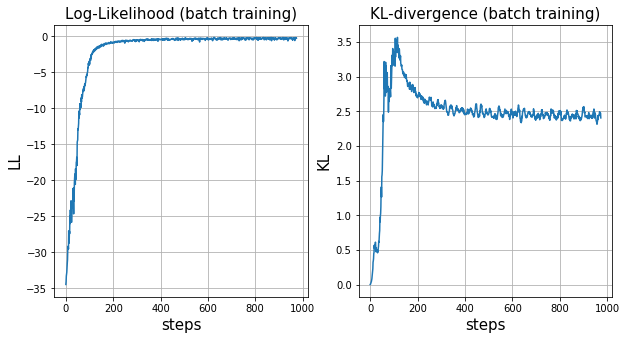

In [316]:
plot_learning_history(train_logs)

In [287]:
train_logs[0][-10:]

[-0.30030524730682373,
 -0.14637240767478943,
 -0.26474320888519287,
 -0.1808272749185562,
 -0.1727052479982376,
 -0.2624013125896454,
 -0.23906446993350983,
 -0.19802796840667725,
 -0.22907474637031555,
 -0.2425348311662674]

In [288]:
X_test = []
for i in range(num_classes):
    X_test.append(get_one_hot_object(i, dim, num_classes))
X_test = np.array(X_test)

In [289]:
model.eval()
recon_batch, log_probs, mu, logvar = model(convert_to_var(X_test))
recon_batch = recon_batch.data.numpy()
log_probs = log_probs.data.numpy()
mu = mu.data.numpy()
logvar = logvar.data.numpy()
std = np.exp(0.5*logvar)

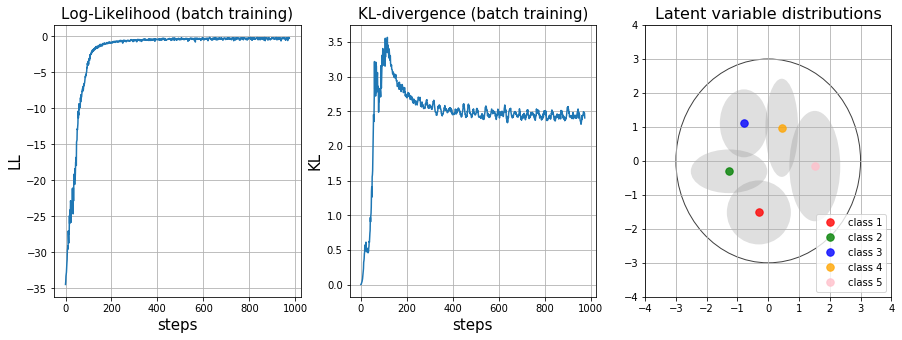

In [315]:
plot_learning_history(train_logs, mu=mu, std=std)

# Онлайн-обучение

### Стационарные данные

In [23]:
def get_obj_log_prob(model, obj, return_loss=False):
    x = np.array([obj])
    probs, log_probs, mu, logvar = model(convert_to_var(x))
    
    if return_loss:
        loss, ll, kld = loss_function(log_probs, convert_to_var(x), mu, logvar, model.n_samples)

    log_probs = log_probs.data.numpy()[0].mean(axis=0)
    log_probs = log_probs[np.arange(dim), obj.astype('int64')]
    obj_log_prob = log_probs.sum()

    if return_loss:
        return obj_log_prob, loss, ll, kld
    else:
        return obj_log_prob

In [204]:
def run(run_iter=None,
       fc_size=1024, num_layers=2, n_samples=25,
       use_adam=True,
       lr=0.0001, momentum=0.9, weight_decay=0, eps=1e-8, centered=False,
       betas=(0.9, 0.99),
       img_name=None):
    
    np.random.seed(11)

    model = VAE(latent_dim=2, input_shape=(-1, dim),
                n_samples=n_samples, fc_size=fc_size, num_layers=num_layers)

    if use_adam:
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas,
                               weight_decay=weight_decay, eps=eps)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum,
                                  weight_decay=weight_decay, eps=eps, centered=centered)

    pgs = []
    train_logs = [[] for _ in range(2)]
    num_steps = int(1e3)
    
    for t in range(num_steps):
        model.train()
        cur_class = np.random.randint(low=0, high=5)            
        obj = get_one_hot_object(cur_class, dim, num_classes)

        log_prob_before, loss, ll, kld = get_obj_log_prob(model, obj, return_loss=True)

        train_logs[0].append(ll.data.numpy()[0])
        train_logs[1].append(kld.data.numpy()[0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        log_prob_after = get_obj_log_prob(model, obj, return_loss=False)

        pg = log_prob_after - log_prob_before
        pgs.append(pg)

                
    if img_name is not None:
        plot_learning_history_with_pgs(train_logs, pgs, filename=img_name)
    else:
        plot_learning_history_with_pgs(train_logs, pgs)
    
    pgs = np.array(pgs)
    pct = (pgs < 0).mean()
    
    lls = np.array(train_logs[0])
    mean_last_ll = lls[-10:].mean()
    
    return mean_last_ll, pct

(-0.32989544, 0.454)

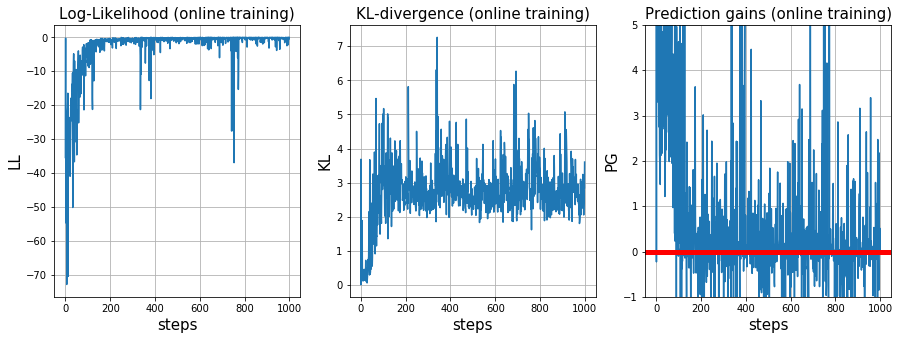

In [328]:
run(run_iter=None,
    fc_size=1024, num_layers=2, n_samples=25,
    use_adam=False,
    lr=0.0005, momentum=0.1, weight_decay=0, eps=1e-8, centered=False)

(-25.592342, 0.001)

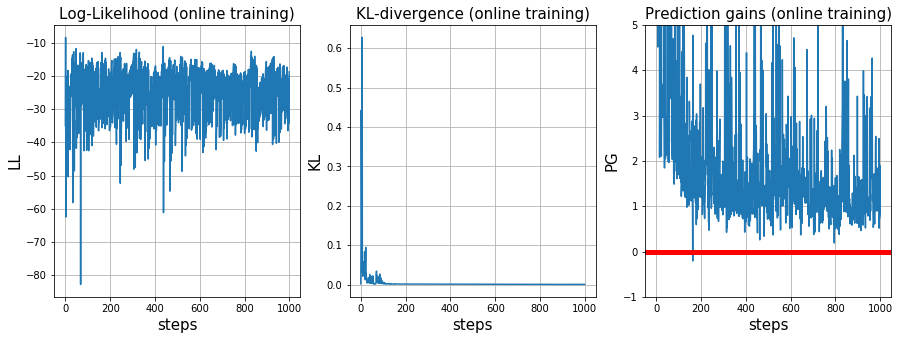

In [330]:
run(run_iter=None,
    fc_size=1024, num_layers=2, n_samples=25,
    use_adam=False,
    lr=0.0005, momentum=0, weight_decay=1, eps=1e-4, centered=False)

## Adam Grid Search


In [94]:
from sklearn.grid_search import ParameterGrid

In [86]:
import os, shutil
def create_empty_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

In [87]:
params_grid = {'use_adam': [True], 
               'lr': [5*1e-4, 1e-4, 5*1e-5, 1e-5],
               'betas': [(0.1, 0.5),  (0.9, 0.5),
                         (0.1, 0.99), (0.9, 0.99)],
               'eps': [1e-4, 1e-8],
               'weight_decay': [0, 1]}

In [92]:
num_vars = 1
for k, v in params_grid.items():
    num_vars *= len(v)
print(num_vars)

64


In [96]:
my_grid = ParameterGrid(params_grid)

In [98]:
for p in my_grid:
    print(str(p))
    break

{'betas': (0.1, 0.5), 'eps': 0.0001, 'lr': 0.0005, 'use_adam': True, 'weight_decay': 0}


In [99]:
np.round(0.12345,2)

0.12

In [115]:
%%time

dir_name = 'adam_grid_search'
create_empty_directory(dir_name)
filename = dir_name + '/' + 'parameters.txt'

with open(filename, 'w') as f:
    pass

results = np.zeros((num_vars,2))
for i, params in enumerate(my_grid):
    try:
        mean_last_ll, pct = run(fc_size=1024, num_layers=2,
                                **params,
                                img_name=dir_name+'/'+str(i+1)+'.jpg')
        print(i, np.round(mean_last_ll,2), np.round(pct,2))
        with open(filename, 'a') as f:
            f.write(str(i+1) + ',' + str(np.round(mean_last_ll,2)) + ', ' + str(np.round(pct,2)) + ',' + \
                   str(params) + '\n')

        results[i][0] = mean_last_ll
        results[i][1] = pct
    except:
         with open(filename, 'a') as f:
            f.write(str(i+1) + ',' + '-' + ',' + '-' + ',' + \
                   str(params) + '\n')


0 -0.95 0.38
1 -26.59 0.0
2 -1.16 0.17
3 -25.44 0.04
4 -3.71 0.23
5 -24.65 0.19
6 -23.06 0.38
7 -24.38 0.34
8 -1.25 0.34
9 -26.6 0.0
10 -1.34 0.17
11 -25.44 0.04
12 -3.74 0.21
13 -13.34 0.22
14 -22.68 0.38
15 -24.26 0.4
16 -17.89 0.37
17 -25.34 0.31
18 -2.81 0.47
19 -7.03 0.42
20 -22.79 0.45
21 -7.48 0.42
22 -11.57 0.5
23 -23.13 0.5
25 -25.37 0.32
27 -6.92 0.42
29 -6.81 0.46
30 -7.07 0.48
31 -24.1 0.47
32 -18.11 0.34
33 -25.52 0.0
34 -1.16 0.35
35 -5.52 0.1
36 -0.86 0.34
37 -4.56 0.21
38 -14.97 0.39
39 -23.93 0.37
40 -0.31 0.37
41 -10.33 0.03
42 -0.85 0.32
43 -4.79 0.1
44 -1.17 0.23
45 -6.91 0.2
46 -12.37 0.38
47 -23.68 0.36
48 -0.2 0.4
49 -25.14 0.31
50 -1.06 0.45
51 -5.61 0.4
52 -0.68 0.45
53 -8.36 0.45
54 -11.5 0.47
55 -24.48 0.46
56 -0.63 0.44
57 -25.16 0.31
58 -0.67 0.41
59 -5.59 0.38
60 -0.87 0.43
61 -6.45 0.47
62 -13.41 0.47
63 -23.94 0.44
CPU times: user 1h 7min 54s, sys: 36 s, total: 1h 8min 30s
Wall time: 25min


In [141]:
results.shape

(64, 2)

In [142]:
np.save('adam_results', results)

In [131]:
s1 = set(np.arange(len(results))[(results[:,1]<0.05) * (results[:,0]!=0)]+1)

In [136]:
s2 = set(np.arange(len(results))[(results[:,0]>-3) * (results[:,0]!=0)]+1)

In [137]:
s1

{2, 4, 10, 12, 34, 42}

In [138]:
s2

{1, 3, 9, 11, 19, 35, 37, 41, 43, 45, 49, 51, 53, 57, 59, 61}

In [139]:
s1&s2

set()

### RMSPROP Grid search

In [146]:
params_grid = {'use_adam': [False], 
               'lr': [5*1e-4, 1e-4, 5*1e-5, 1e-5],
               'momentum':[0, 0.1, 0.5, 0.9],
               'eps': [1e-4, 1e-8],
               'weight_decay': [0, 1]}

In [147]:
num_vars = 1
for k, v in params_grid.items():
    num_vars *= len(v)
print(num_vars)

64


In [148]:
my_grid = ParameterGrid(params_grid)

In [149]:
%%time

dir_name = 'rmsprop_grid_search'
create_empty_directory(dir_name)
filename = dir_name + '/' + 'parameters.txt'

with open(filename, 'w') as f:
    pass

rmsprop_results = np.zeros((num_vars,2))
for i, params in enumerate(my_grid):
    try:
        mean_last_ll, pct = run(fc_size=1024, num_layers=2,
                                **params,
                                img_name=dir_name+'/'+str(i+1)+'.jpg')
        print(i, np.round(mean_last_ll,2), np.round(pct,2))
        with open(filename, 'a') as f:
            f.write(str(i+1) + ',' + str(np.round(mean_last_ll,2)) + ', ' + str(np.round(pct,2)) + ',' + \
                   str(params) + '\n')

        rmsprop_results[i][0] = mean_last_ll
        rmsprop_results[i][1] = pct
    except:
         with open(filename, 'a') as f:
            f.write(str(i+1) + ',' + '-' + ',' + '-' + ',' + \
                   str(params) + '\n')


0 -0.45 0.46
1 -25.56 0.0
2 -0.37 0.45
3 -25.63 0.0
4 -1.77 0.45
5 -25.97 0.02
6 -7.89 0.4
7 -12.59 0.19
8 -1.17 0.37
9 -6.6 0.07
10 -0.93 0.35
11 -6.7 0.07
12 -0.43 0.36
13 -7.19 0.1
14 -0.22 0.44
15 -10.67 0.3
16 -0.81 0.34
17 -6.83 0.16
18 -0.83 0.33
19 -7.61 0.15
20 -0.9 0.37
21 -6.19 0.2
22 -0.67 0.43
23 -25.12 0.32
24 -10.74 0.38
25 -24.01 0.32
26 -9.93 0.36
27 -23.61 0.39
28 -4.62 0.37
29 -16.99 0.39
30 -0.58 0.43
31 -4.67 0.4
32 -1.53 0.43
33 -25.67 0.0
34 -0.42 0.42
35 -25.65 0.0
36 -0.23 0.32
37 -25.9 0.02
38 -2.38 0.4
39 -12.14 0.17
40 -0.5 0.36
41 -6.14 0.07
42 -0.82 0.39
43 -6.41 0.08
44 -0.84 0.38
45 -7.48 0.13
46 -0.37 0.43
47 -10.35 0.28
48 -0.84 0.34
49 -5.18 0.18
50 -0.82 0.36
51 -6.55 0.15
52 -0.36 0.37
53 -5.99 0.19
54 -0.4 0.44
55 -25.1 0.31
56 -16.03 0.38
57 -23.69 0.35
58 -20.89 0.35
59 -23.79 0.33
60 -2.65 0.37
61 -24.12 0.34
62 -0.94 0.43
63 -5.04 0.43
CPU times: user 1h 10min 29s, sys: 43 s, total: 1h 11min 12s
Wall time: 27min 35s


#### s1 - Индексы, у которых процент PG<0 меньше 0.05, и которые не выбросили исключение

In [163]:
s1 = set(np.arange(num_vars)[(rmsprop_results[:,1]<0.05) * (rmsprop_results[:,0]!=0)]+1)
print(s1)

{2, 34, 4, 36, 6, 38}


#### s2 - Индексы, у которых LL > -3 и которые не выбросили исключение

In [172]:
s2 = set(np.arange(num_vars)[(rmsprop_results[:,0]>-3) * (rmsprop_results[:,0]!=0)]+1)
print(s2)

{1, 3, 5, 9, 11, 13, 15, 17, 19, 21, 23, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 61, 63}


#### s3 - Индексы, у которых LL > -0.5 и которые не выбросили исключение

In [201]:
s3 = set(np.arange(num_vars)[(rmsprop_results[:,0]>-0.25) * (rmsprop_results[:,0]!=0)]+1)
print(s3)

{37, 15}


In [202]:
with open(filename) as f:
    lines = f.readlines()

In [203]:
for i in range(len(lines)):
    if i+1 in s3:
        l = lines[i].strip()
        pos = l.find('eps')
        print(l[pos:])

eps': 0.0001, 'lr': 0.0001, 'momentum': 0.9, 'use_adam': False, 'weight_decay': 0}
eps': 1e-08, 'lr': 0.0005, 'momentum': 0.5, 'use_adam': False, 'weight_decay': 0}


In [150]:
np.save('rmsprop_results',rmsprop_results)

In [152]:
rmsprop_results.shape

(64, 2)

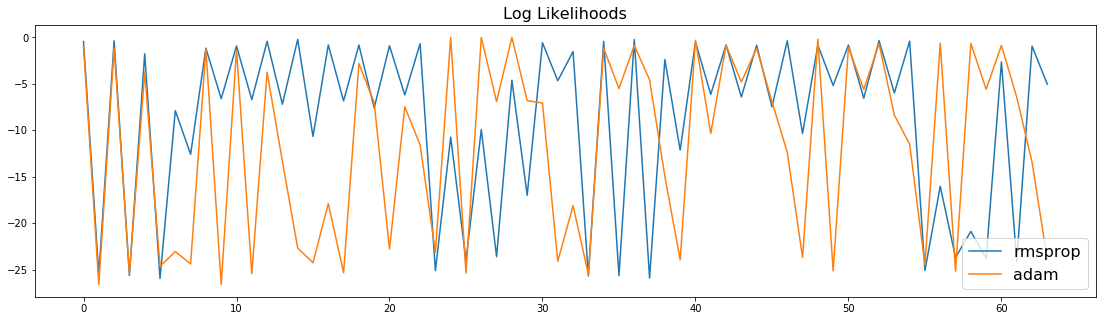

In [160]:
plt.figure(figsize=(19,5))
plt.plot(rmsprop_results[:,0], label='rmsprop')
plt.plot(results[:,0], label='adam')
plt.legend(loc='lower right', fontsize=16)
plt.title('Log Likelihoods', fontsize=16)

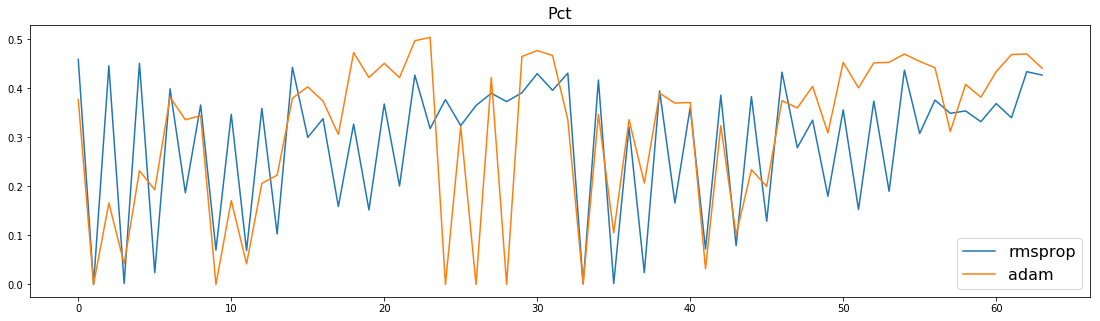

In [161]:
plt.figure(figsize=(19,5))
plt.plot(rmsprop_results[:,1], label='rmsprop')
plt.plot(results[:,1], label='adam')
plt.legend(loc='lower right', fontsize=16)
plt.title('Pct', fontsize=16)

### Выводы:
1) Лучше выбирать RMSprob, так как для рассмотренных наборов гиперпараметров (для каждого алгоритма по 64 случая) значительно он большее количество раз получил приемлимый LL в конце. При этом в данной задаче для RMSPROP нужно брать lr=1e-4 и momentum=0.5 или 0.9.


2) Для обоих методов стабильно PG>0, если KL -> 0, а LL при этом не обучается и колеблется на одном уровне. Во всех этих случаях есть регуляризация, которая предположительно оставляет mu~0 и logvar~0 (std->0) и не дает обучаться
encode'y.

## Исследование зависимости от n_samples.

In [213]:
n_samples_range = [1, 10, 25, 50, 100, 250, 1000, 10000]
pcts = []
lls = []

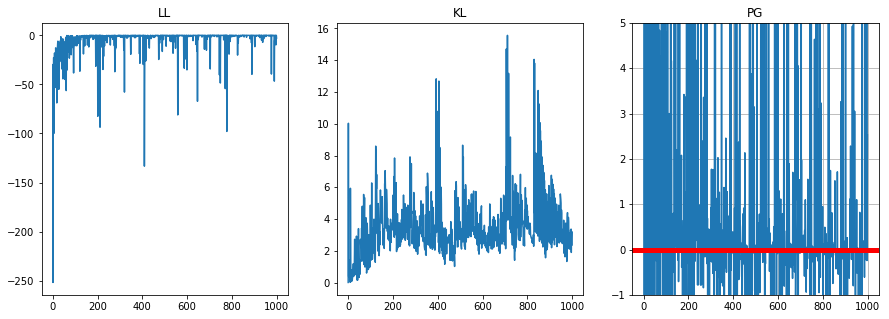

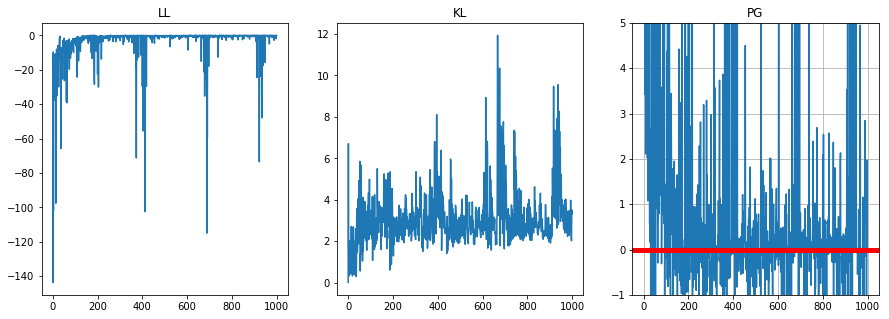

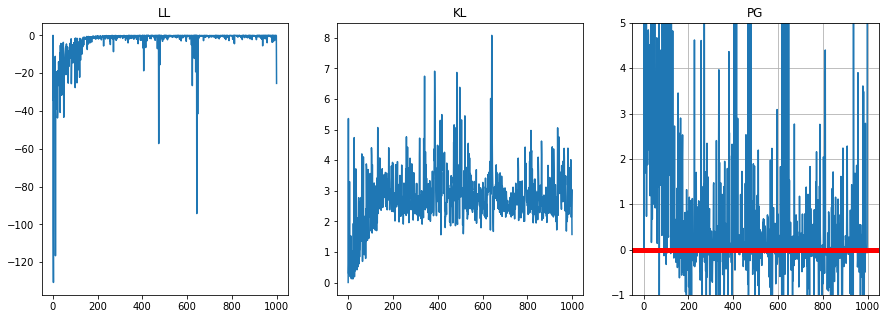

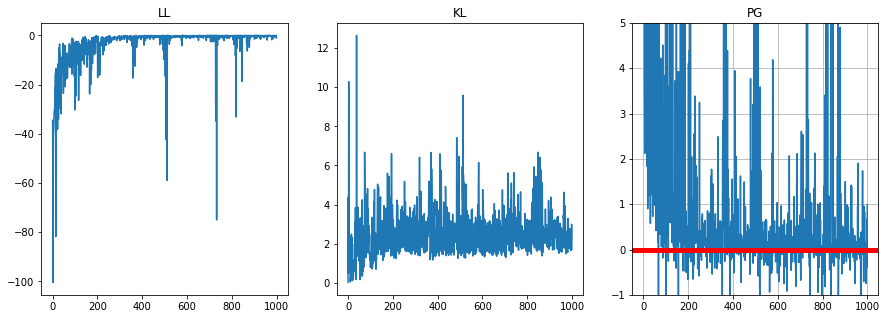

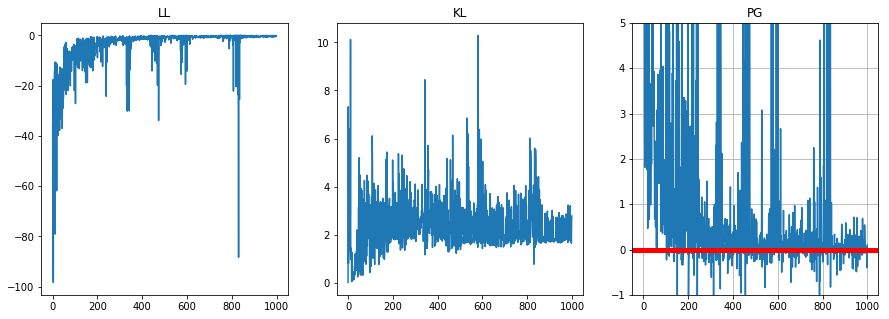

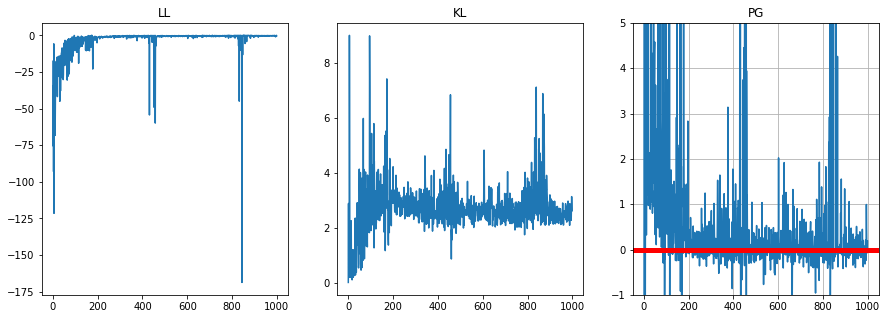

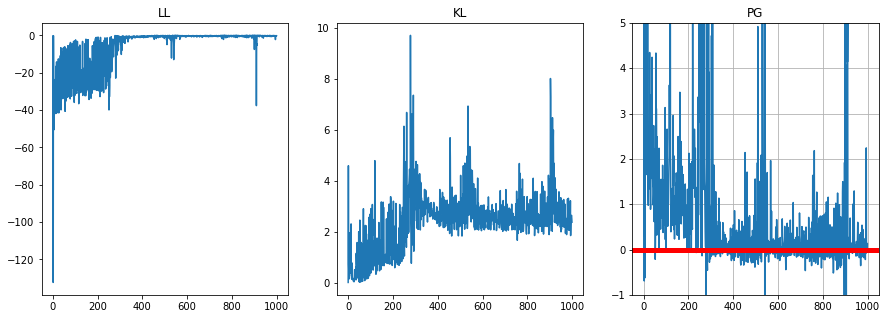

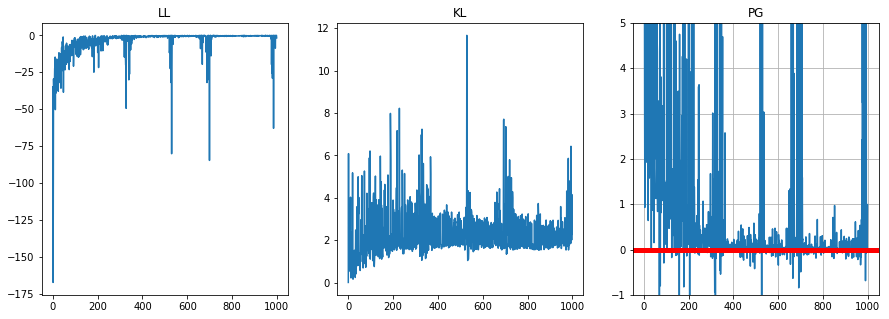

In [214]:
for n_samples in n_samples_range:
    mean_last_ll, pct = run(fc_size=1024, num_layers=2,
                            n_samples=n_samples,
                            use_adam=False, lr=0.0005, momentum=0.5, eps=1e-8)
    lls.append(mean_last_ll)
    pcts.append(pct)

In [215]:
pcts

[0.472, 0.45, 0.43, 0.348, 0.311, 0.383, 0.325, 0.23]

In [216]:
lls

[-2.232709,
 -0.24008572,
 -2.871641,
 -0.36923602,
 -0.32808346,
 -0.38887173,
 -0.4567852,
 -1.4760149]

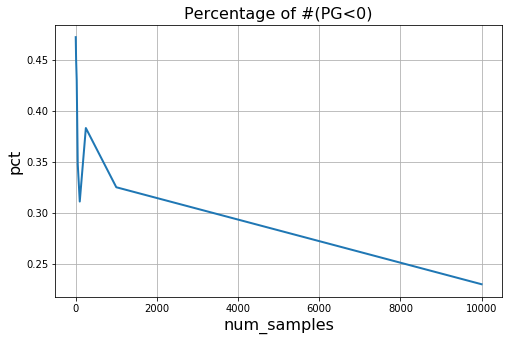

In [228]:
plt.figure(figsize=(8,5))
plt.plot(n_samples_range, pcts, linewidth=2)
plt.xlabel('num_samples', fontsize=16)
plt.ylabel('pct', fontsize=16)
plt.title('Percentage of #(PG<0)', fontsize=16)
plt.grid()

## Пример 1
2 Слоя, результаты обучения похожи на обучение по батчам, но PG в 13% шагов отрицательный.

##### Adam

CPU times: user 53.8 s, sys: 408 ms, total: 54.2 s
Wall time: 18.2 s


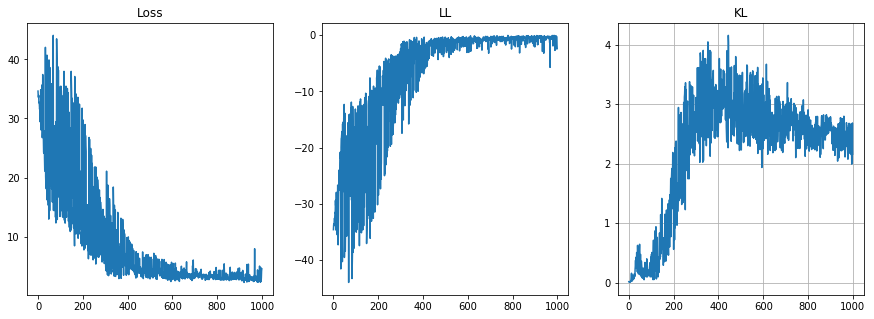

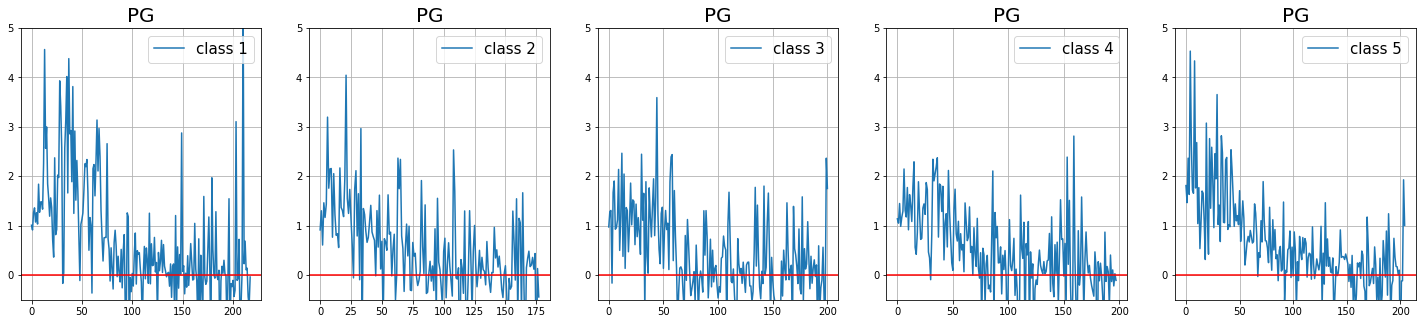

In [377]:
%%time
results = run(fc_size=1024, num_layers=2,
              lr=0.0001, betas=(0.01, 0.5))

In [35]:
steps, chosen_classes, pgs, real_counters, model, train_logs = results

In [36]:
print(model)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=50, out_features=1024)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=512, out_features=2)
  (fc_logvar): Linear(in_features=512, out_features=2)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=512)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=100)
  )
)


In [37]:
int((np.array(pgs)<0).mean()*100)

26

In [38]:
train_logs[1][-10:]

[-0.3210035,
 -0.37858552,
 -0.3762787,
 -0.37093934,
 -0.45503944,
 -0.52913266,
 -0.10139768,
 -0.3516724,
 -0.76701224,
 -0.5156509]

In [382]:
model.eval()
recon_batch, log_probs, mu, logvar = model(convert_to_var(X_test))
recon_batch = recon_batch.data.numpy()
log_probs = log_probs.data.numpy()
mu = mu.data.numpy()
logvar = logvar.data.numpy()
std = np.exp(0.5*logvar)

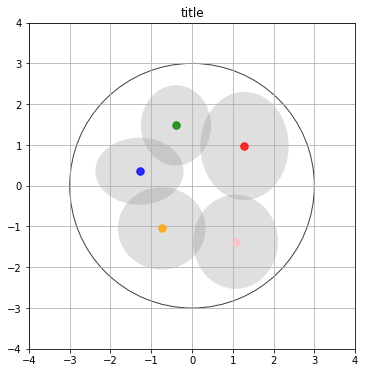

In [383]:
plot_point_with_std(mu, std)

In [384]:
recon_batch.sum(axis=1)

array([10.0293455, 19.99203  , 30.010593 , 39.991158 , 49.802353 ],
      dtype=float32)

##### Rmsprop

CPU times: user 55.2 s, sys: 432 ms, total: 55.7 s
Wall time: 19.2 s


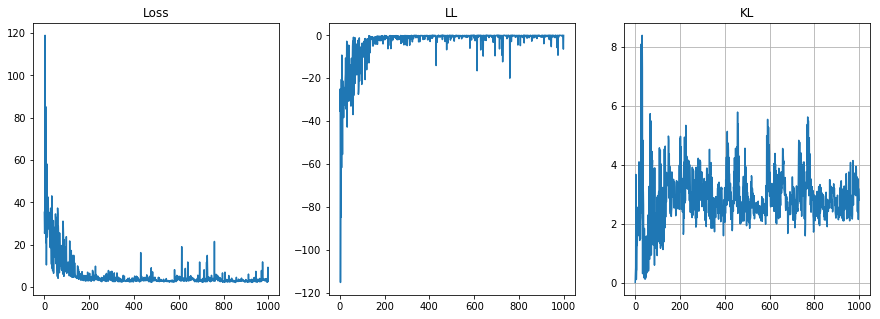

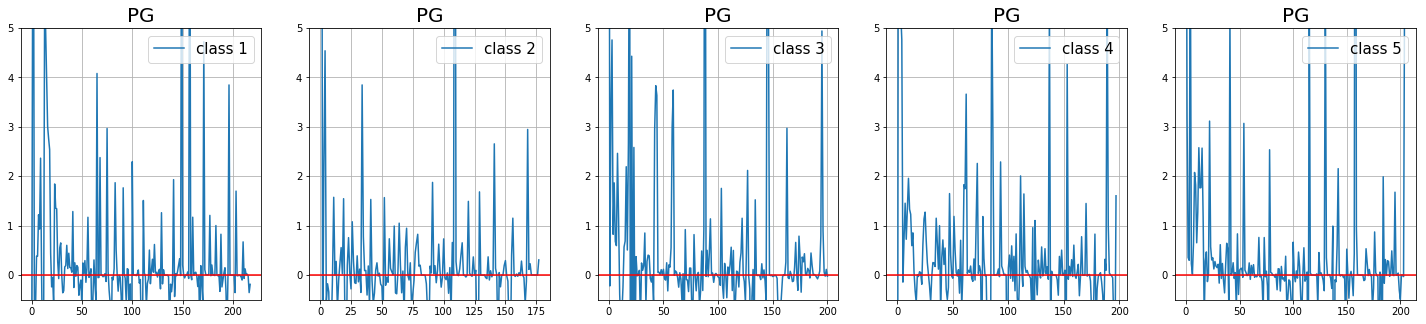

In [386]:
%%time
results = run(fc_size=1024, num_layers=2,
              use_adam=False, lr=0.0001, momentum=0.9)

In [387]:
steps, chosen_classes, pgs, real_counters, model, train_logs = results

In [392]:
train_logs[1][-10:]

[-0.25347316,
 -0.30764252,
 -0.04913029,
 -0.13208535,
 -0.010228494,
 -0.015068224,
 -0.19316149,
 -2.0241275,
 -6.413655,
 -0.03849261]

In [389]:
int((np.array(pgs)<0).mean()*100)

44

In [390]:
model.eval()
recon_batch, log_probs, mu, logvar = model(convert_to_var(X_test))
recon_batch = recon_batch.data.numpy()
log_probs = log_probs.data.numpy()
mu = mu.data.numpy()
logvar = logvar.data.numpy()
std = np.exp(0.5*logvar)

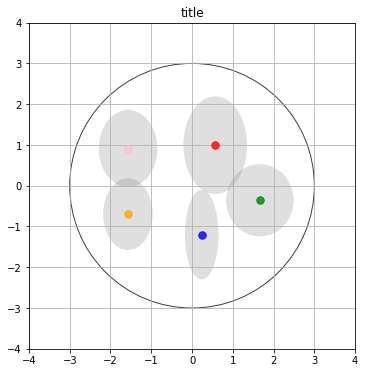

In [391]:
plot_point_with_std(mu, std)